In [1]:
import sys
import os
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras import layers, models, callbacks
from sklearn.model_selection import train_test_split

sys.path.append(os.path.abspath(os.path.join('..', 'src')))

from data_loader import load_bearing_data, compute_melspec, creadte_dataset_windows

c:\Users\kweru\Desktop\EchoGuard\.venv\Lib\site-packages\keras\src\export\tf2onnx_lib.py:8: FutureWarning: In the future `np.object` will be defined as the corresponding NumPy scalar.
  if not hasattr(np, "object"):


In [2]:
DATA_DIR = '../data/raw/2nd_test'
files = sorted(os.listdir(DATA_DIR))

healthy_files = files[0:100]
failure_files = files[-5]

print(f'Loading {len(healthy_files)} data...')

all_windows = []
for filename in healthy_files:
	df = load_bearing_data(filename, DATA_DIR)
	melspec = compute_melspec(df)
	norm_mel = (melspec - (-80)) / (0 - (-80))
	windows = creadte_dataset_windows(norm_mel)
	all_windows.append(windows)

X_train = np.concatenate(all_windows, axis=0)
print(f'Traing data shape: {X_train.shape}')

df_failure = load_bearing_data(failure_files, DATA_DIR)
mel_fail = compute_melspec(df_failure)
norm_fail = (mel_fail - (-80)) / (0 - (-80))
X_test_anomaly = creadte_dataset_windows(norm_fail)

print(f'Anomaly shape: {X_test_anomaly.shape}')


Loading 100 data...
Traing data shape: (400, 128, 64, 1)
Anomaly shape: (4, 128, 64, 1)


In [3]:
def build_autoencoder(input_shape):
	model = models.Sequential()
	model.add(layers.Input(shape=input_shape))
	
	model.add(layers.Conv2D(32, (3,3), activation='relu', padding='same'))
	model.add(layers.MaxPooling2D((2,2), padding='same'))
	model.add(layers.Conv2D(16, (3,3), activation='relu', padding='same'))
	model.add(layers.MaxPooling2D((2,2), padding='same'))
	model.add(layers.Conv2D(8, (3,3), activation='relu', padding='same'))
	model.add(layers.MaxPooling2D((2,2), padding='same'))

	model.add(layers.Conv2D(8, (3,3), activation='relu', padding='same'))
	model.add(layers.UpSampling2D((2,2)))
	model.add(layers.Conv2D(16, (3,3), activation='relu', padding='same'))
	model.add(layers.UpSampling2D((2,2)))
	model.add(layers.Conv2D(32, (3,3), activation='relu', padding='same'))
	model.add(layers.UpSampling2D((2,2)))
	
	model.add(layers.Conv2D(1, (3,3), activation='sigmoid', padding='same'))

	return model

input_shape = (128, 64, 1)
model = build_autoencoder(input_shape)

model.compile(optimizer='adam', loss='mse')

model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 128, 64, 32)    │           320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 64, 32, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 64, 32, 16)     │         4,624 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 32, 16, 16)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 32, 16, 8)      │         1,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 16, 8, 8)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (None, 16, 8, 8)       │           584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ up_sampling2d (UpSampling2D)    │ (None, 32, 16, 8)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_4 (Conv2D)               │ (None, 32, 16, 16)     │         1,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ up_sampling2d_1 (UpSampling2D)  │ (None, 64, 32, 16)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_5 (Conv2D)               │ (None, 64, 32, 32)     │         4,640 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ up_sampling2d_2 (UpSampling2D)  │ (None, 128, 64, 32)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_6 (Conv2D)               │ (None, 128, 64, 1)     │           289 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 12,785 (49.94 KB)

 Trainable params: 12,785 (49.94 KB)

 Non-trainable params: 0 (0.00 B)

In [4]:
X_train_split, X_val_split = train_test_split(X_train, test_size=0.1, random_state=42)

In [5]:

early_stopping = tf.keras.callbacks.EarlyStopping(
    monitor='val_loss',
    patience=5,
    mode='min',
    restore_best_weights=True
)

history = model.fit(
    X_train_split, X_train_split, 
    epochs=50,
    batch_size=64,
    validation_data=(X_val_split, X_val_split),
    callbacks=[early_stopping],
    shuffle=True 
)


Epoch 1/50
6/6 ━━━━━━━━━━━━━━━━━━━━ 3s 194ms/step - loss: 0.0482 - val_loss: 0.0172
Epoch 2/50
6/6 ━━━━━━━━━━━━━━━━━━━━ 1s 85ms/step - loss: 0.0117 - val_loss: 0.0133
Epoch 3/50
6/6 ━━━━━━━━━━━━━━━━━━━━ 1s 82ms/step - loss: 0.0082 - val_loss: 0.0062
Epoch 4/50
6/6 ━━━━━━━━━━━━━━━━━━━━ 1s 83ms/step - loss: 0.0067 - val_loss: 0.0047
Epoch 5/50
6/6 ━━━━━━━━━━━━━━━━━━━━ 1s 94ms/step - loss: 0.0047 - val_loss: 0.0045
Epoch 6/50
6/6 ━━━━━━━━━━━━━━━━━━━━ 1s 89ms/step - loss: 0.0040 - val_loss: 0.0039
Epoch 7/50
6/6 ━━━━━━━━━━━━━━━━━━━━ 1s 81ms/step - loss: 0.0037 - val_loss: 0.0034
Epoch 8/50
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step - loss: 0.0032 - val_loss: 0.0030
Epoch 9/50
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 75ms/step - loss: 0.0029 - val_loss: 0.0028
Epoch 10/50
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 76ms/step - loss: 0.0028 - val_loss: 0.0027
Epoch 11/50
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 74ms/step - loss: 0.0027 - val_loss: 0.0026
Epoch 12/50
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step - loss: 0.0026 - val_loss: 0.0026


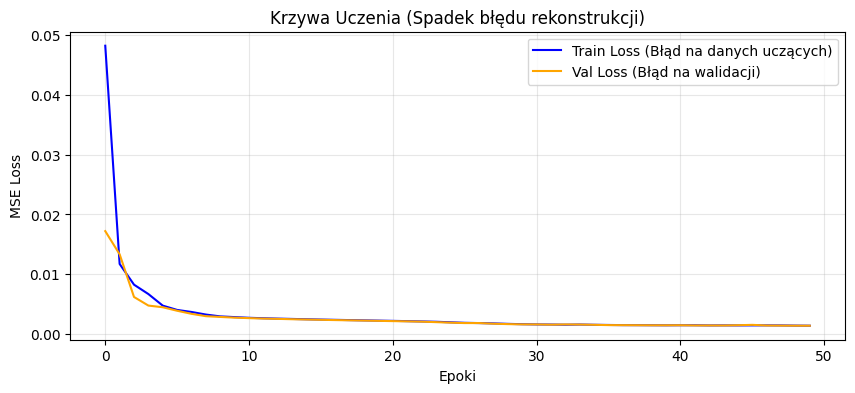

In [6]:
plt.figure(figsize=(10, 4))
plt.plot(history.history['loss'],
         label='Train Loss (Błąd na danych uczących)', color='blue')
plt.plot(history.history['val_loss'],
         label='Val Loss (Błąd na walidacji)', color='orange')
plt.title('Krzywa Uczenia (Spadek błędu rekonstrukcji)')
plt.xlabel('Epoki')
plt.ylabel('MSE Loss')
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 163ms/step


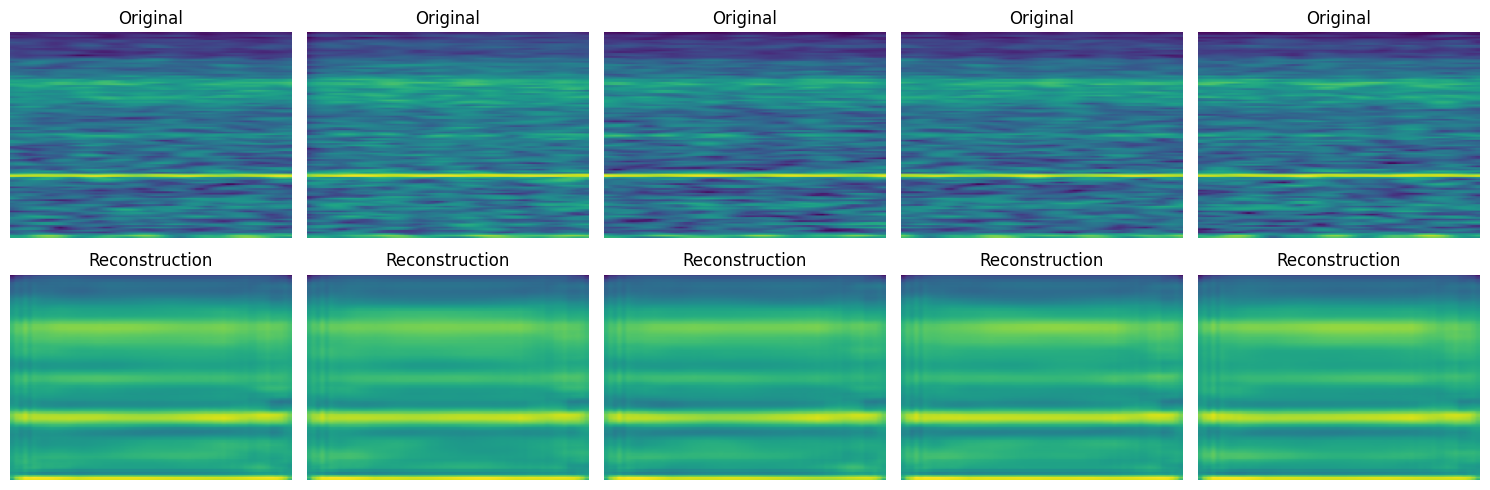

In [7]:
decoded_imgs = model.predict(X_val_split)

def plot_reconstruction(orginal, reconstruction, n=5):
	plt.figure(figsize=(15,5))
	for i in range(n):
		ax = plt.subplot(2, n, i + 1)
        
		plt.imshow(orginal[i].squeeze(), cmap='viridis', origin='lower', aspect='auto')
		plt.title('Original')
		plt.axis('off')

		ax = plt.subplot(2, n, i+1+n)
		plt.imshow(reconstruction[i].squeeze(), cmap='viridis', origin='lower', aspect='auto')
		plt.title('Reconstruction')
		plt.axis('off')
	plt.tight_layout()
	plt.show()

plot_reconstruction(X_val_split, decoded_imgs)

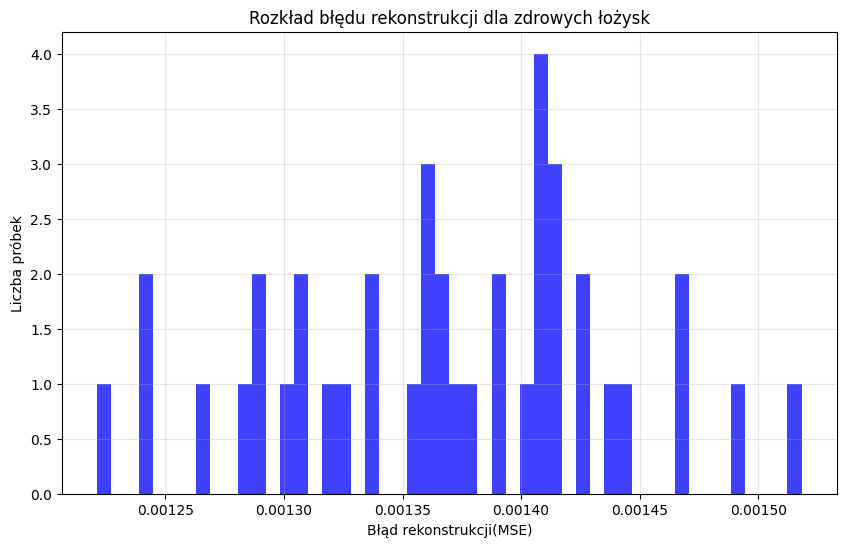

In [8]:
reconstruction_errors = np.mean(np.power(X_val_split - decoded_imgs, 2), axis=(1,2,3))

plt.figure(figsize=(10, 6))
plt.hist(reconstruction_errors, bins=50, alpha=0.75, color='blue', label='(Train/Val)')
plt.xlabel('Błąd rekonstrukcji(MSE)')
plt.ylabel('Liczba próbek')
plt.title('Rozkład błędu rekonstrukcji dla zdrowych łożysk')
plt.grid(True, alpha=0.3)
plt.show()

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
Max Healty MSE: 0.001518
Średni błąd na anomalii: 0.008389


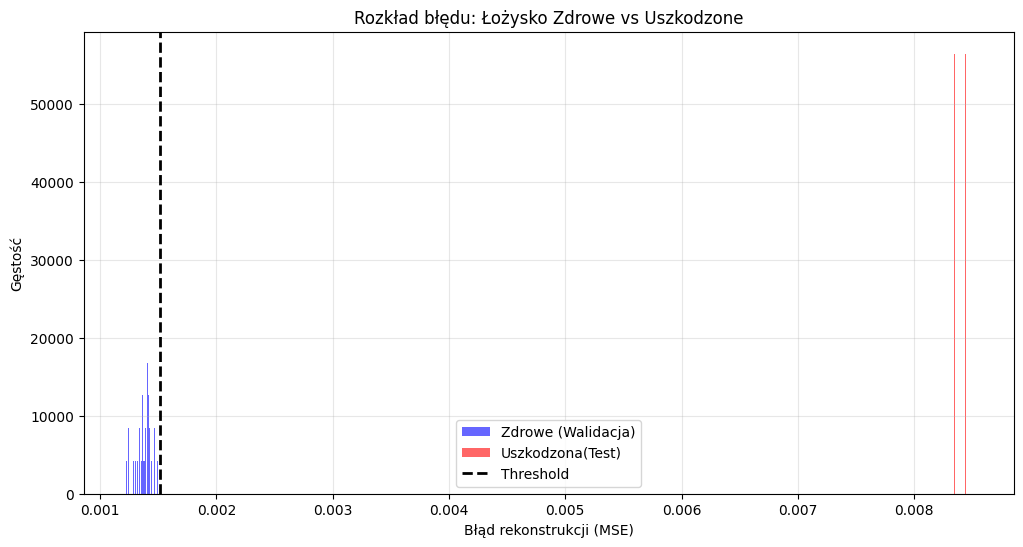


--- WYNIKI DETEKCJI ---
Liczba próbek w pliku uszkodzonym: 4
Liczba próbek uznanych za awarię: 4
Skuteczność detekcji: 100.00%


In [9]:
pred_val = model.predict(X_val_split)
pred_anomaly = model.predict(X_test_anomaly)

mse_healty = np.mean(np.power(X_val_split - pred_val, 2), axis=(1,2,3))
mse_anomaly = np.mean(np.power(X_test_anomaly - pred_anomaly, 2), axis=(1,2,3))

THRESHOLD = np.max(mse_healty)
print(f'Max Healty MSE: {THRESHOLD:.6f}')
print(f'Średni błąd na anomalii: {np.mean(mse_anomaly):.6f}')

plt.figure(figsize=(12, 6))
plt.hist(mse_healty, bins=50, alpha=0.6, color='blue', label="Zdrowe (Walidacja)", density=True)
plt.hist(mse_anomaly, bins=50, alpha=0.6, color='red', label="Uszkodzona(Test)", density=True)

plt.axvline(THRESHOLD, color='black', linestyle='--', linewidth=2, label='Threshold')

plt.title('Rozkład błędu: Łożysko Zdrowe vs Uszkodzone')
plt.xlabel('Błąd rekonstrukcji (MSE)')
plt.ylabel('Gęstość')
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()

detected_faults = np.sum(mse_anomaly > THRESHOLD)
total_windows = len(mse_anomaly)

print(f"\n--- WYNIKI DETEKCJI ---")
print(f"Liczba próbek w pliku uszkodzonym: {total_windows}")
print(f"Liczba próbek uznanych za awarię: {detected_faults}")
print(f"Skuteczność detekcji: {100 * detected_faults / total_windows:.2f}%")

All files
Done!


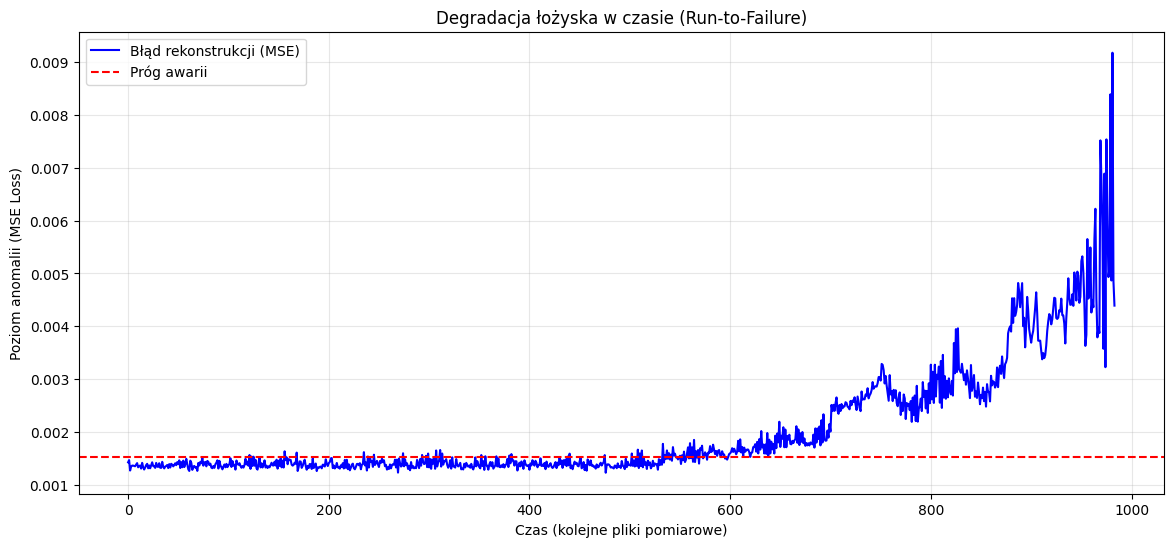

In [10]:
mse_history = []

print('All files')

for filename in files:
    df_temp = load_bearing_data(filename, DATA_DIR)
    if df_temp.shape[0] < 100:
        continue
    
    melspec_temp = compute_melspec(df_temp)
    norm_temp = (melspec_temp - (-80)) / (0 - (-80))
    
    X_temp = creadte_dataset_windows(norm_temp)
    if len(X_temp) == 0:
        continue
    
    reconstructions = model.predict(X_temp, verbose=0)
    mse_temp = np.mean(np.power(X_temp - reconstructions, 2))
    mse_history.append(mse_temp)
    
print("Done!")

# --- WIZUALIZACJA KRZYWEJ ŻYCIA ---
plt.figure(figsize=(14, 6))
plt.plot(mse_history, label='Błąd rekonstrukcji (MSE)',
         color='blue', linewidth=1.5)

# Rysujemy linię progu, którą wyznaczyłeś wcześniej
plt.axhline(y=THRESHOLD, color='red', linestyle='--', label='Próg awarii')

plt.title('Degradacja łożyska w czasie (Run-to-Failure)')
plt.xlabel('Czas (kolejne pliki pomiarowe)')
plt.ylabel('Poziom anomalii (MSE Loss)')
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()

In [11]:
import json

MODEL_DIR = os.path.join('..', 'models')
CONFIG_DIR = os.path.join('..', 'config')

os.makedirs(MODEL_DIR, exist_ok=True)
os.makedirs(CONFIG_DIR, exist_ok=True)

keras_path = os.path.join(MODEL_DIR, 'bearing_anomaly_detector.keras')
model.save(keras_path)
print(f"Model zapisany w: {keras_path}")

config_data = {
    'threshold': float(THRESHOLD),
    'norm_min': -80.0,
    'norm_max': 0.0
}

config_path = os.path.join(CONFIG_DIR, 'model_config.json')
with open(config_path, 'w') as f:
    json.dump(config_data, f, indent=4)

print(f"Konfiguracja zapisana w: {config_path}")

Model zapisany w: ..\models\bearing_anomaly_detector.keras
Konfiguracja zapisana w: ..\config\model_config.json


In [12]:
import os
import tf2onnx

# Ścieżki
MODEL_DIR = os.path.join('..', 'models')
TEMP_TF_MODEL_DIR = "temp_tf_model_export"
ONNX_PATH = os.path.join(MODEL_DIR, 'bearing_model.onnx')

print(f"Wersja tf2onnx: {tf2onnx.__version__}")
# Powinieneś widzieć 1.16.1

# Uruchomienie konwersji
# Ignore dependencies warnings - we are forcing it to run
print("Start konwersji...")
!python -m tf2onnx.convert --saved-model {TEMP_TF_MODEL_DIR} --output {ONNX_PATH} --opset 16

if os.path.exists(ONNX_PATH):
    print(f"\n🚀 SUKCES! Mamy to: {ONNX_PATH}")
else:
    print("\n❌ Nadal problem. Pokaż błędy.")



Wersja tf2onnx: 1.16.1
Start konwersji...

🚀 SUKCES! Mamy to: ..\models\bearing_model.onnx


c:\Users\kweru\Desktop\EchoGuard\.venv\Lib\site-packages\keras\src\export\tf2onnx_lib.py:8: FutureWarning: In the future `np.object` will be defined as the corresponding NumPy scalar.
  if not hasattr(np, "object"):


<frozen runpy>:128: RuntimeWarning: 'tf2onnx.convert' found in sys.modules after import of package 'tf2onnx', but prior to execution of 'tf2onnx.convert'; this may result in unpredictable behaviour
2026-01-05 10:08:57,440 - WARNING - '--tag' not specified for saved_model. Using --tag serve
2026-01-05 10:08:57,555 - INFO - Signatures found in model: [serve,serving_default].
2026-01-05 10:08:57,555 - WARNING - '--signature_def' not specified, using first signature: serve
2026-01-05 10:08:57,555 - INFO - Output names: ['output_0']
I0000 00:00:1767604137.558300   31696 devices.cc:76] Number of eligible GPUs (core count >= 8, compute capability >= 0.0): 0 (Note: TensorFlow was not compiled with CUDA or ROCm support)
I0000 00:00:1767604137.558522   31696 single_machine.cc:376] 